### This notebook contains a comparison between Encoder-Decoder, Encoder Only and LSTM approaches

In [1]:
import nltk
from nltk.corpus import names
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd

# Load NLTK names dataset
nltk.download('names')
male_names = names.words('male.txt')
female_names = names.words('female.txt')

[nltk_data] Downloading package names to /Users/laasya/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [2]:
# Combine and encode names
all_names = male_names + female_names
labels = [0] * len(male_names) + [1] * len(female_names)  # 0 for male, 1 for female

# Convert names to ASCII values
names_ascii = [[ord(char) for char in name.lower()] for name in all_names]

# Pad sequences
names_padded = pad_sequences(names_ascii, padding='post')

# Shuffle data
indices = np.arange(len(labels))
np.random.shuffle(indices)
names_padded = names_padded[indices]
labels = np.array(labels)[indices]


In [3]:
print(f"Number of Male Names:",len(male_names))
print(f"Number of Female Names:", len(female_names))

Number of Male Names: 2943
Number of Female Names: 5001


#### Imbalanced classes - Let's adjust class weights

In [4]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
names_train, names_test, labels_train, labels_test = train_test_split(names_padded, labels, test_size=0.2, random_state=42)

# Split train data into train and val sets
names_train, names_val, labels_train, labels_val = train_test_split(names_train, labels_train, test_size = 0.25, random_state = 42)

In [5]:
# The dataset is heavily imbalanced
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights which will be passed to model during training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_train),
    y=labels_train)

class_weight_dict = dict(enumerate(class_weights))

In [6]:
# Decode Names
def decode_names(encoded_names):
    decoded_names = []
    for name in encoded_names:
        decoded_name = ''.join(chr(char) for char in name if char != 0)  # Convert ASCII back to characters and ignore padding
        decoded_names.append(decoded_name)
    return decoded_names

decoded_names_test = decode_names(names_test)

label_map = lambda x: "Male" if x == 0 else "Female"

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [8]:
def get_positional_encoding(max_seq_length, d_model):
    angle_rads = np.arange(max_seq_length)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [9]:
def scaled_dot_product_attention(q, k, v, mask):    
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    
    # Scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # Softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAtention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0  # Ensure the model size is divisible by the number of heads

        self.depth = d_model // self.num_heads  # Define the depth

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # scaled_dot_product_attention function needs to be correctly implemented or called here
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

In [10]:
def transformer_encoder(inputs, num_heads, d_model, dff, rate):
    # Multi-head attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed forward network
    ffn_output = Dense(dff, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

In [11]:
def transformer_decoder(inputs, enc_output, num_heads, d_model, dff, rate):
    # Encoder-decoder attention
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, enc_output)
    attn1 = Dropout(rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn1)

    # Feed forward network
    ffn = Dense(dff, activation='relu')(out1)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(rate)(ffn)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn)

# Encoder-Decoder approach

I am going to try encoder-decoder approach. A decoder is not necessary for a binary classification. I will also try Encoder only after this.

In [12]:
def build_transformer_classifier(vocab_size, max_length, num_layers, num_heads, d_model, dff, rate=0.1):
    inputs = Input(shape=(max_length,))
    embeddings = Embedding(vocab_size, d_model)(inputs)
    
    # Encoder processing
    enc_output = embeddings
    for _ in range(num_layers):
        enc_output = transformer_encoder(enc_output, num_heads, d_model, dff, rate)

    # Decoder processing
    dec_output = enc_output
    for _ in range(num_layers):
        dec_output = transformer_decoder(dec_output, enc_output, num_heads, d_model, dff, rate)

    # Using the output from the last token for classification
    final_output = dec_output[:, -1, :]  # Assuming the last token's output is representative

    outputs = Dense(2, activation='softmax')(final_output)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Encoder only approach

In [13]:
def build_encoder_only_classifier(vocab_size, max_length, num_layers, num_heads, d_model, dff, rate=0.1):
    inputs = Input(shape=(max_length,))
    embeddings = Embedding(vocab_size, d_model)(inputs)
    
    enc_output = embeddings
    for _ in range(num_layers):
        enc_output = transformer_encoder(enc_output, num_heads, d_model, dff, rate)
    cls_token_output = enc_output[:, 0, :]  # This assumes that the first token is like a CLS token

    outputs = Dense(2, activation='softmax')(cls_token_output)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# LSTM based approach

In [14]:
from tensorflow.keras.layers import LSTM, Bidirectional

def build_lstm_model(vocab_size, max_length, lstm_units):
    inputs = Input(shape=(max_length,))
    x = Embedding(vocab_size, 64)(inputs)
    # Setting return_sequences=False to get output from the last timestep
    x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Training the Models

In [15]:
# Assuming models are built and compiled, and data is prepared
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 128
max_length = 15
num_layers = 2
num_heads = 8
d_model = 32
dff = 256
rate = 0.01

# Setup for Transformer model
transformer_model = build_transformer_classifier(vocab_size, max_length, num_layers, num_heads, d_model, dff, rate)

# Setup for Encoder only model
encoder_only = build_encoder_only_classifier(vocab_size, max_length, num_layers, num_heads, d_model, dff, rate)

# Setup for LSTM model
lstm_units = 128
lstm_model = build_lstm_model(vocab_size, max_length, lstm_units)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("#"*140)
print("Transformer based Encoder-Decoder approach.")
# Train the Encoder-Decoder model
ed_history = transformer_model.fit(
    names_train, labels_train,
    # class_weight=class_weight_dict,
    validation_data=(names_val, labels_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

print("#"*140)
print("Transformer based Encoder only approach.")
# Train the Encoder Only model
e_history = encoder_only.fit(
    names_train, labels_train,
    # class_weight=class_weight_dict,
    validation_data=(names_val, labels_val),
    epochs=20,
    batch_size=32,
    # callbacks=[early_stopping]
)

print("#"*140)
print("LSTM approach.")
# Train the LSTM model
lstm_history = lstm_model.fit(
    names_train, labels_train,
    # class_weight=class_weight_dict,
    validation_data=(names_val, labels_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

############################################################################################################################################
Transformer based Encoder-Decoder approach.
Epoch 1/20
149/149 [==============================] - 4s 18ms/step - loss: 0.6573 - accuracy: 0.6418 - val_loss: 0.5555 - val_accuracy: 0.7206
Epoch 2/20
149/149 [==============================] - 3s 21ms/step - loss: 0.5744 - accuracy: 0.7021 - val_loss: 0.5529 - val_accuracy: 0.7143
Epoch 3/20
149/149 [==============================] - 3s 21ms/step - loss: 0.5724 - accuracy: 0.6983 - val_loss: 0.5653 - val_accuracy: 0.7124
Epoch 4/20
149/149 [==============================] - 3s 21ms/step - loss: 0.5555 - accuracy: 0.7193 - val_loss: 0.5627 - val_accuracy: 0.7231
Epoch 5/20
149/149 [==============================] - 3s 21ms/step - loss: 0.5548 - accuracy: 0.7146 - val_loss: 0.5375 - val_accuracy: 0.7181
Epoch 6/20
149/149 [==============================] - 3s 22ms/step - loss: 0.5526 - accuracy: 0.7245

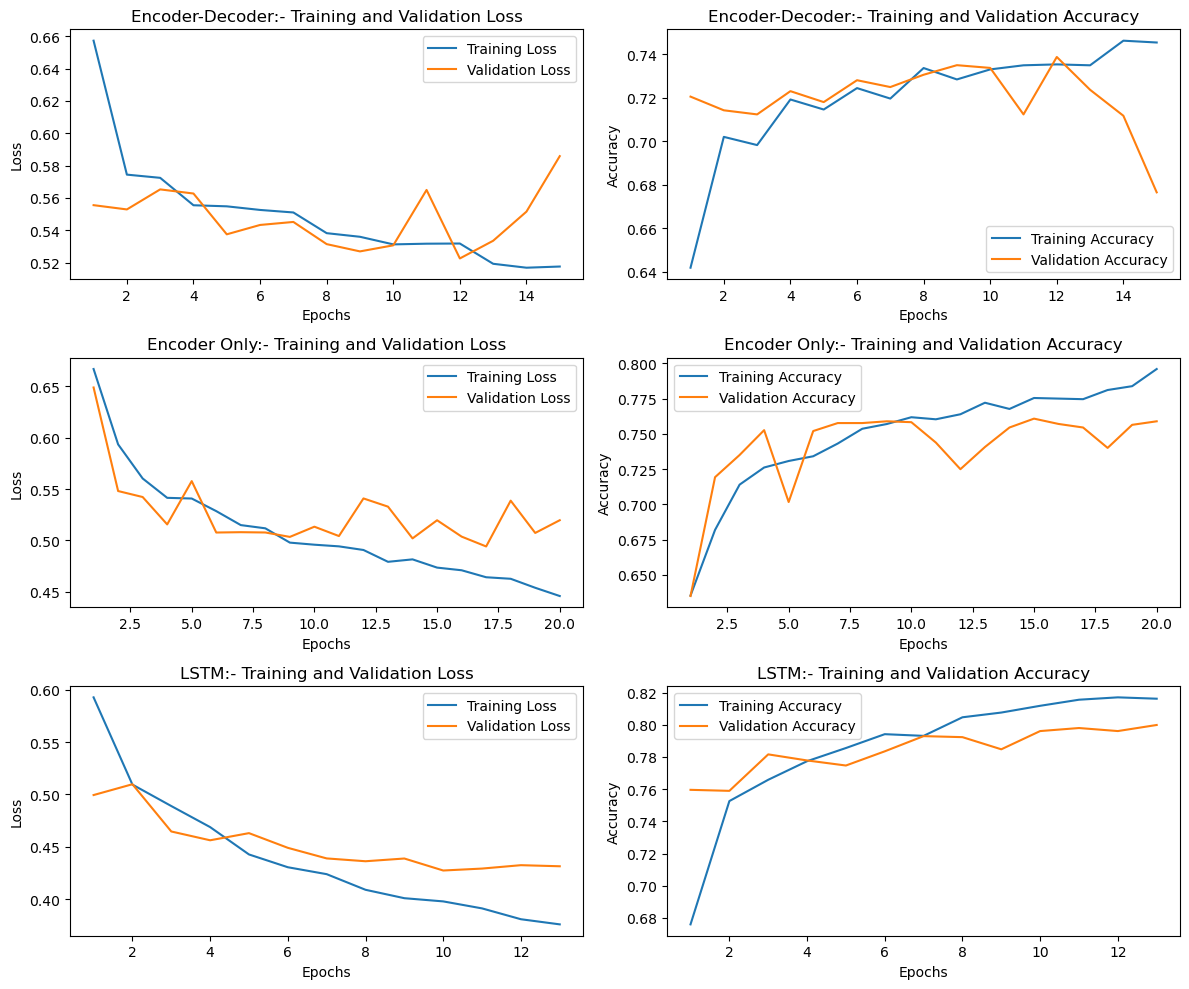

In [16]:
# Encoder - Decoder
ed_train_loss = ed_history.history['loss']
ed_val_loss = ed_history.history['val_loss']
ed_train_accuracy = ed_history.history['accuracy']  
ed_val_accuracy = ed_history.history['val_accuracy']
ed_epochs = range(1, len(ed_train_loss) + 1)  # Range of epochs (1 to number of epochs)

# Encoder only
e_train_loss = e_history.history['loss']
e_val_loss = e_history.history['val_loss']
e_train_accuracy = e_history.history['accuracy']  
e_val_accuracy = e_history.history['val_accuracy']
e_epochs = range(1, len(e_train_loss) + 1)  # Range of epochs (1 to number of epochs)

# LSTM
lstm_train_loss = lstm_history.history['loss']
lstm_val_loss = lstm_history.history['val_loss']
lstm_train_accuracy = lstm_history.history['accuracy']  
lstm_val_accuracy = lstm_history.history['val_accuracy']
lstm_epochs = range(1, len(lstm_train_loss) + 1)  # Range of epochs (1 to number of epochs)

plt.figure(figsize=(12, 10))

# Subplot for the ED loss
plt.subplot(3, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(ed_epochs, ed_train_loss, label='Training Loss')
plt.plot(ed_epochs, ed_val_loss, label='Validation Loss')
plt.title('Encoder-Decoder:- Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for the ED accuracy
plt.subplot(3, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(ed_epochs, ed_train_accuracy, label='Training Accuracy')
plt.plot(ed_epochs, ed_val_accuracy, label='Validation Accuracy')
plt.title('Encoder-Decoder:- Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for the E only loss
plt.subplot(3, 2, 3)  # 1 row, 2 columns, first subplot
plt.plot(e_epochs, e_train_loss, label='Training Loss')
plt.plot(e_epochs, e_val_loss, label='Validation Loss')
plt.title('Encoder Only:- Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for the E only accuracy
plt.subplot(3, 2, 4)  # 1 row, 2 columns, second subplot
plt.plot(e_epochs, e_train_accuracy, label='Training Accuracy')
plt.plot(e_epochs, e_val_accuracy, label='Validation Accuracy')
plt.title('Encoder Only:- Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Subplot for the LSTM loss
plt.subplot(3, 2, 5)  # 1 row, 2 columns, first subplot
plt.plot(lstm_epochs, lstm_train_loss, label='Training Loss')
plt.plot(lstm_epochs, lstm_val_loss, label='Validation Loss')
plt.title('LSTM:- Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for the LSTM accuracy
plt.subplot(3, 2, 6)  # 1 row, 2 columns, second subplot
plt.plot(lstm_epochs, lstm_train_accuracy, label='Training Accuracy')
plt.plot(lstm_epochs, lstm_val_accuracy, label='Validation Accuracy')
plt.title('LSTM:- Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for all the plots
plt.show()

In [17]:
# Make predictions on Encoder-Decoder
ed_test_predictions = transformer_model.predict(names_test)
ed_test_predicted_classes = np.argmax(ed_test_predictions, axis=1)

ed_pred_vs_actual = pd.concat([pd.Series(decoded_names_test),pd.Series(ed_test_predicted_classes).apply(label_map), pd.Series(labels_test).apply(label_map)],
                                     keys = ["name", "predicted", "actual"],axis=1)

print("#"*100)
print("Encoder-Decoder Pred vs Actual")
print(ed_pred_vs_actual)
print("#"*100)

50/50 [==============================] - 1s 15ms/step
####################################################################################################
Encoder-Decoder Pred vs Actual
          name predicted  actual
0     marjorie    Female  Female
1        marys    Female  Female
2         aili    Female  Female
3        denny    Female  Female
4      isadore    Female    Male
...        ...       ...     ...
1584  shepperd      Male    Male
1585     elise    Female  Female
1586    karlie    Female  Female
1587      tove      Male  Female
1588  veronike    Female  Female

[1589 rows x 3 columns]
####################################################################################################


In [18]:
# Make predictions on Encoder Only
e_test_predictions = encoder_only.predict(names_test)
e_test_predicted_classes = np.argmax(e_test_predictions, axis=1)

e_pred_vs_actual = pd.concat([pd.Series(decoded_names_test),pd.Series(e_test_predicted_classes).apply(label_map), pd.Series(labels_test).apply(label_map)],
                                     keys = ["name", "predicted", "actual"],axis=1)

print("#"*100)
print("Encoder Only Pred vs Actual")
print(e_pred_vs_actual)
print("#"*100)

50/50 [==============================] - 0s 8ms/step
####################################################################################################
Encoder Only Pred vs Actual
          name predicted  actual
0     marjorie    Female  Female
1        marys    Female  Female
2         aili    Female  Female
3        denny    Female  Female
4      isadore    Female    Male
...        ...       ...     ...
1584  shepperd      Male    Male
1585     elise    Female  Female
1586    karlie    Female  Female
1587      tove      Male  Female
1588  veronike    Female  Female

[1589 rows x 3 columns]
####################################################################################################


In [19]:
# Make predictions on LSTM
lstm_test_predictions = lstm_model.predict(names_test)
lstm_test_predicted_classes = np.argmax(lstm_test_predictions, axis=1)

lstm_pred_vs_actual = pd.concat([pd.Series(decoded_names_test),pd.Series(lstm_test_predicted_classes).apply(label_map), pd.Series(labels_test).apply(label_map)],
                                     keys = ["name", "predicted", "actual"],axis=1)

print("#"*100)
print("LSTM Pred vs Actual")
print(lstm_pred_vs_actual)
print("#"*100)

50/50 [==============================] - 1s 8ms/step
####################################################################################################
LSTM Pred vs Actual
          name predicted  actual
0     marjorie    Female  Female
1        marys    Female  Female
2         aili    Female  Female
3        denny    Female  Female
4      isadore    Female    Male
...        ...       ...     ...
1584  shepperd      Male    Male
1585     elise    Female  Female
1586    karlie    Female  Female
1587      tove      Male  Female
1588  veronike    Female  Female

[1589 rows x 3 columns]
####################################################################################################


In [20]:
# Wrong Encode-Decoder predictions
print(ed_pred_vs_actual[ed_pred_vs_actual.predicted != ed_pred_vs_actual.actual])

          name predicted  actual
4      isadore    Female    Male
5     rosamond      Male  Female
6     horatius    Female    Male
10      zollie    Female    Male
15        gale    Female    Male
...        ...       ...     ...
1566    tomiko      Male  Female
1568      iago    Female    Male
1580    freddi      Male  Female
1582    hassan    Female    Male
1587      tove      Male  Female

[417 rows x 3 columns]


In [21]:
# Wrong Encode Only predictions
print(e_pred_vs_actual[e_pred_vs_actual.predicted != e_pred_vs_actual.actual])

          name predicted  actual
4      isadore    Female    Male
5     rosamond      Male  Female
10      zollie    Female    Male
12    srinivas    Female    Male
15        gale    Female    Male
...        ...       ...     ...
1568      iago    Female    Male
1576     lorne      Male  Female
1580    freddi      Male  Female
1582    hassan    Female    Male
1587      tove      Male  Female

[357 rows x 3 columns]


In [22]:
# Wrong LSTM predictions
print(lstm_pred_vs_actual[lstm_pred_vs_actual.predicted != lstm_pred_vs_actual.actual])

          name predicted  actual
4      isadore    Female    Male
5     rosamond      Male  Female
10      zollie    Female    Male
15        gale    Female    Male
16     eustace    Female    Male
...        ...       ...     ...
1548    janean      Male  Female
1566    tomiko      Male  Female
1570   xymenes    Female    Male
1579     estel      Male  Female
1587      tove      Male  Female

[290 rows x 3 columns]


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    return accuracy, precision, recall, f1

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [24]:
# Evaluate Encoder-Decoder Model
accuracy_ed, precision_ed, recall_ed, f1_ed = evaluate_model(transformer_model, names_test, labels_test)
print(f"Encoder-Decoder Model:-\nAccuracy: {accuracy_ed}\nPrecision: {precision_ed}\nRecall: {recall_ed}\nF1 Score: {f1_ed}")

50/50 [==============================] - 1s 16ms/step
Encoder-Decoder Model:-
Accuracy: 0.7375707992448081
Precision: 0.7557840616966581
Recall: 0.8698224852071006
F1 Score: 0.8088033012379643


In [25]:
# Evaluate Encoder only Model
accuracy_ed, precision_ed, recall_ed, f1_ed = evaluate_model(encoder_only, names_test, labels_test)
print(f"Encoder Only Model:-\nAccuracy: {accuracy_ed}\nPrecision: {precision_ed}\nRecall: {recall_ed}\nF1 Score: {f1_ed}")

50/50 [==============================] - 0s 9ms/step
Encoder Only Model:-
Accuracy: 0.775330396475771
Precision: 0.7854039965247611
Recall: 0.8915187376725838
F1 Score: 0.8351039260969977


In [26]:
# Evaluate LSTM Model
accuracy_lstm, precision_lstm, recall_lstm, f1_lstm = evaluate_model(lstm_model, names_test, labels_test)
print(f"LSTM Model:-\nAccuracy: {accuracy_lstm}\nPrecision: {precision_lstm}\nRecall: {recall_lstm}\nF1 Score: {f1_lstm}")

50/50 [==============================] - 0s 6ms/step
LSTM Model:-
Accuracy: 0.8174952800503461
Precision: 0.8358070500927643
Recall: 0.888560157790927
F1 Score: 0.861376673040153


######################### Encoder-Decoder #########################


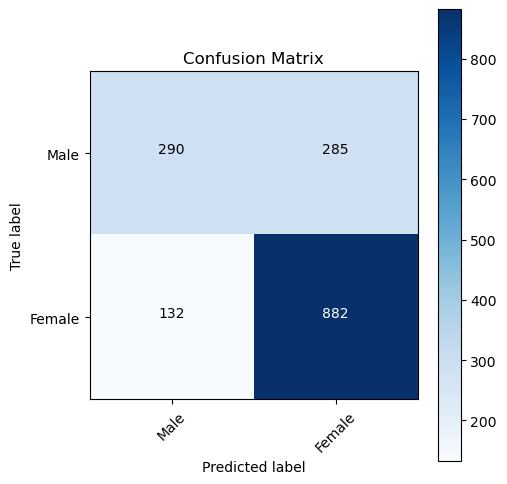

In [27]:
print("#"*25, "Encoder-Decoder", "#"*25)
cm = confusion_matrix(labels_test, ed_test_predicted_classes)
plot_confusion_matrix(cm, ["Male", "Female"])

Very high False Positives. 

######################### Encoder Only #########################


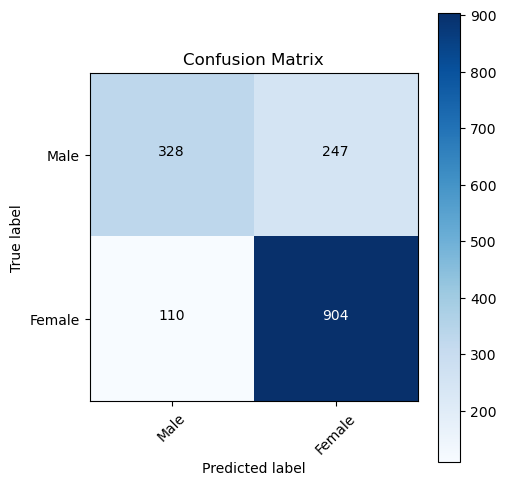

In [28]:
print("#"*25, "Encoder Only", "#"*25)
cm = confusion_matrix(labels_test, e_test_predicted_classes)
plot_confusion_matrix(cm, ["Male", "Female"])

High False Positivies

######################### LSTM #########################


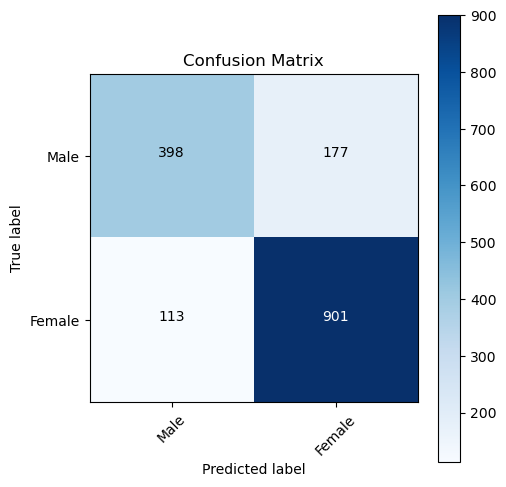

In [29]:
print("#"*25, "LSTM", "#"*25)
cm = confusion_matrix(labels_test, lstm_test_predicted_classes)
plot_confusion_matrix(cm, ["Male", "Female"])

Balance between False Positives and False Negatives